In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import yaml
import shutil
from datetime import datetime

sns.set_theme()

In [2]:
### All global variables that would be passed as arguments in a python script
micro_benchmarks_data = "/home/nils/Documents/TU_Berlin/Work_DIMA/NES/nebulastream-public/window_management/benchmark_scripts/micro-benchmarks-data"
input_csv_file = f"{micro_benchmarks_data}/benchmark_task_size_113034.csv"
output_folder_plots = f"{micro_benchmarks_data}"


In [3]:
def parse_line(name_value):
    parts = name_value.split('/')
    if len(parts) < 6:
        return pd.Series({
            "No. Tuples": None,
            "No. Tuples / Task": None,
            "Sleep / Tup" : None,
            "Selectivity": None,
            "BufferSize": None,
            "Provider": None,
            "No. Threads": None
        })
    return pd.Series({
        "No. Tuples / Task": parts[2],
        "Sleep / Tup" : parts[3],
        "Selectivity": parts[4],
        "BufferSize": parts[5],
        "Provider": parts[6],
        "No. Threads": parts[7]
    })

def load_data(filename):
    df = pd.read_csv(filename)
    df = remove_rows(df)
    df_new = df.join(df["name"].apply(parse_line))
    df_new = convert_to_seconds(df_new)

    # Calculating some useful statistics
    for col in ["Provider", "No. Threads", "Sleep / Tup", "No. Tuples / Task", "Number_Of_Tasks"]:
        df_new[col] = pd.to_numeric(df_new[col], errors='ignore')
    time_unit = df_new.iloc[0]['time_unit']
    df_new['No. Tasks'] = df_new['Number_Of_Tasks']
    df_new['No. Tuples'] = df_new['Tuples_Processed']
    df_new["tuples_per_sec"] = df_new["No. Tuples"] / df_new["real_time_sec"]
    df_new = df_new.sort_values(by=['No. Tuples / Task'])
    df_new['sub_left_side'] = df_new['real_time_ms'] * 1000
    df_new['sub_right_side'] = (df_new['Sleep / Tup'] * df_new['No. Tuples']) / df_new['No. Threads']
    df_new['time_extra_us'] = df_new['sub_left_side'] - df_new['sub_right_side']
    df_new['time_extra_ms'] = df_new['time_extra_us'] / 1000
    df_new['time_extra_ms_per_tuple'] = df_new['time_extra_ms'] / df_new['No. Tuples']
    #df = df[df['time_extra'] >= 0]

    # Dropping some columns
    columns_to_drop=['error_message', 'error_occurred', 'label', 'cpu_time', 'Thread_0_Processed_Tuples', 'items_per_second', 'bytes_per_second']
    df_new.drop(columns=columns_to_drop, inplace=True)
    return df_new

# Removing all rows that end in "_stddev", "_median", "_mean", "_cv"
def remove_rows(df):
    suffix_list = ["_stddev", "_median", "_mean", "_cv"]
    target_column = 'name'
    df[target_column] = df[target_column].astype(str)
    mask = df[target_column].str.endswith(tuple(suffix_list))
    df_filtered = df[~mask]
    return df_filtered

def convert_to_seconds(df):
    """Adds a new column 'real_time_sec' to df, converting 'real_time' based on 'time_unit'."""
    time_multipliers = {
        "ns": 1e-9,  # Nanoseconds to seconds
        "us": 1e-6,  # Microseconds to seconds
        "ms": 1e-3,  # Milliseconds to seconds
        "s": 1,      # Seconds (no change)
        "sec": 1     # Alternate label for seconds
    }
    
    df["real_time_sec"] = df["real_time"] * df["time_unit"].map(time_multipliers)
    df["real_time_ms"] = df["real_time_sec"] * 1000
    return df

# Load data into dataframe and then remove rows
df = load_data(input_csv_file)

if df.empty:
    print("No data loaded; check the input file format.")
    sys.exit(1)

df = df[df['time_extra_us'] >0]
df

/tmp/ipykernel_16274/1164804785.py:30: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_new[col] = pd.to_numeric(df_new[col], errors='ignore')


,name,iterations,real_time,time_unit,Number_Of_Tasks,Tuples_Processed,No. Tuples / Task,Sleep / Tup,Selectivity,BufferSize,...,real_time_sec,real_time_ms,No. Tasks,No. Tuples,tuples_per_sec,sub_left_side,sub_right_side,time_extra_us,time_extra_ms,time_extra_ms_per_tuple
448,NES::BM_SleepPipeline/10000/25/1/10/16384/1/4/...,1,2640.45,ms,400,10000,25,1,10,16384,...,2.64045,2640.45,400,10000,3787.233237,2640450.0,2500.0,2637950.0,2637.95,0.263795
449,NES::BM_SleepPipeline/10000/25/1/10/16384/1/4/...,1,2640.76,ms,400,10000,25,1,10,16384,...,2.64076,2640.76,400,10000,3786.788652,2640760.0,2500.0,2638260.0,2638.26,0.263826
450,NES::BM_SleepPipeline/10000/25/1/10/16384/1/4/...,1,2640.37,ms,400,10000,25,1,10,16384,...,2.64037,2640.37,400,10000,3787.347985,2640370.0,2500.0,2637870.0,2637.87,0.263787
451,NES::BM_SleepPipeline/10000/25/1/10/16384/1/4/...,1,2640.67,ms,400,10000,25,1,10,16384,...,2.64067,2640.67,400,10000,3786.917714,2640670.0,2500.0,2638170.0,2638.17,0.263817
455,NES::BM_SleepPipeline/10000/25/1/10/16384/1/4/...,1,2640.44,ms,400,10000,25,1,10,16384,...,2.64044,2640.44,400,10000,3787.247580,2640440.0,2500.0,2637940.0,2637.94,0.263794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,NES::BM_SleepPipeline/10000/400/1/10/16384/1/1...,1,10554.60,ms,25,10000,400,1,10,16384,...,10.55460,10554.60,25,10000,947.454191,10554600.0,10000.0,10544600.0,10544.60,1.054460
213,NES::BM_SleepPipeline/10000/400/1/10/16384/1/1...,1,10569.90,ms,25,10000,400,1,10,16384,...,10.56990,10569.90,25,10000,946.082744,10569900.0,10000.0,10559900.0,10559.90,1.055990
212,NES::BM_SleepPipeline/10000/400/1/10/16384/1/1...,1,10564.30,ms,25,10000,400,1,10,16384,...,10.56430,10564.30,25,10000,946.584251,10564300.0,10000.0,10554300.0,10554.30,1.055430
211,NES::BM_SleepPipeline/10000/400/1/10/16384/1/1...,1,10565.20,ms,25,10000,400,1,10,16384,...,10.56520,10565.20,25,10000,946.503616,10565200.0,10000.0,10555200.0,10555.20,1.055520


/tmp/ipykernel_16274/1164804785.py:30: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_new[col] = pd.to_numeric(df_new[col], errors='ignore')
/tmp/ipykernel_16274/2950381674.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


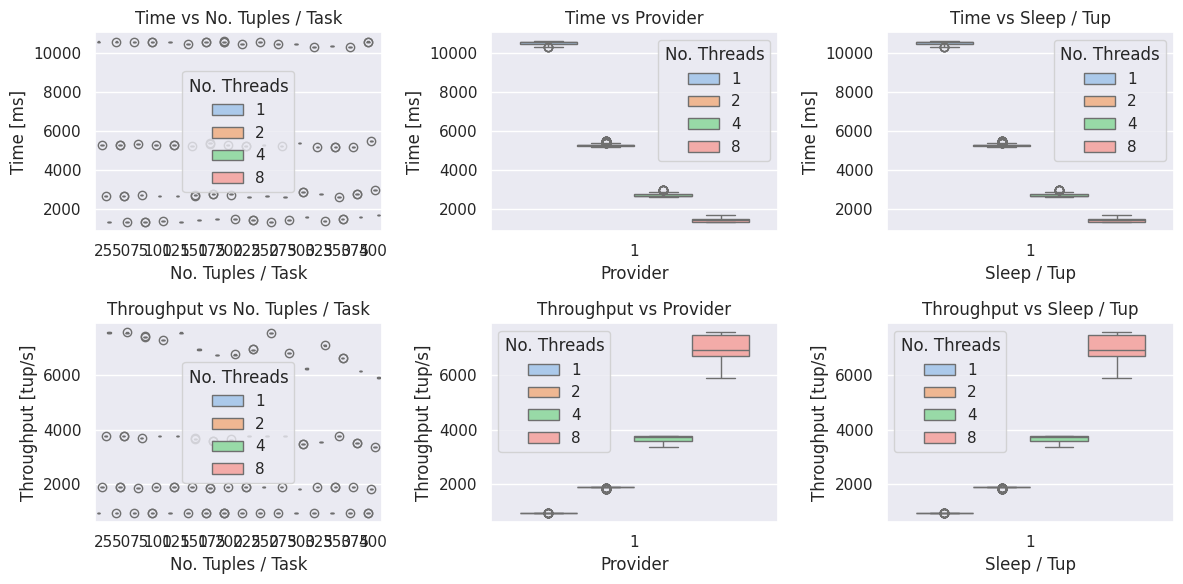

In [4]:
# Load data into dataframe and then plot different boxplots
df = load_data(input_csv_file)

interesting_params = ["No. Tuples / Task", "Provider", "Sleep / Tup"]
for col in interesting_params + ["No. Tuples", "Provider"]:
    df[col] = pd.to_numeric(df[col], errors='ignore')
time_unit = df.iloc[0]['time_unit']
df["tuples_per_sec"] = df["No. Tuples"] / df["real_time_sec"]


# Create a subplot grid.
n_params = len(interesting_params)
fig, axes = plt.subplots(2, n_params, figsize=(4*n_params, 6), squeeze=False)

for idx, param in enumerate(interesting_params):
    ax = axes[0][idx]
    sns.boxplot(x=param, y="real_time_ms", hue='No. Threads', data=df, ax=ax, palette="pastel")
    ax.set_title(f"Time vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Time [ms]")
    #ax.set_ylim([0, .04])

    ax = axes[1][idx]
    sns.boxplot(x=param, y="tuples_per_sec", hue='No. Threads', data=df, ax=ax, palette="pastel")
    ax.set_title(f"Throughput vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Throughput [tup/s]")

plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()
plt.close()

/tmp/ipykernel_16274/1164804785.py:30: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_new[col] = pd.to_numeric(df_new[col], errors='ignore')


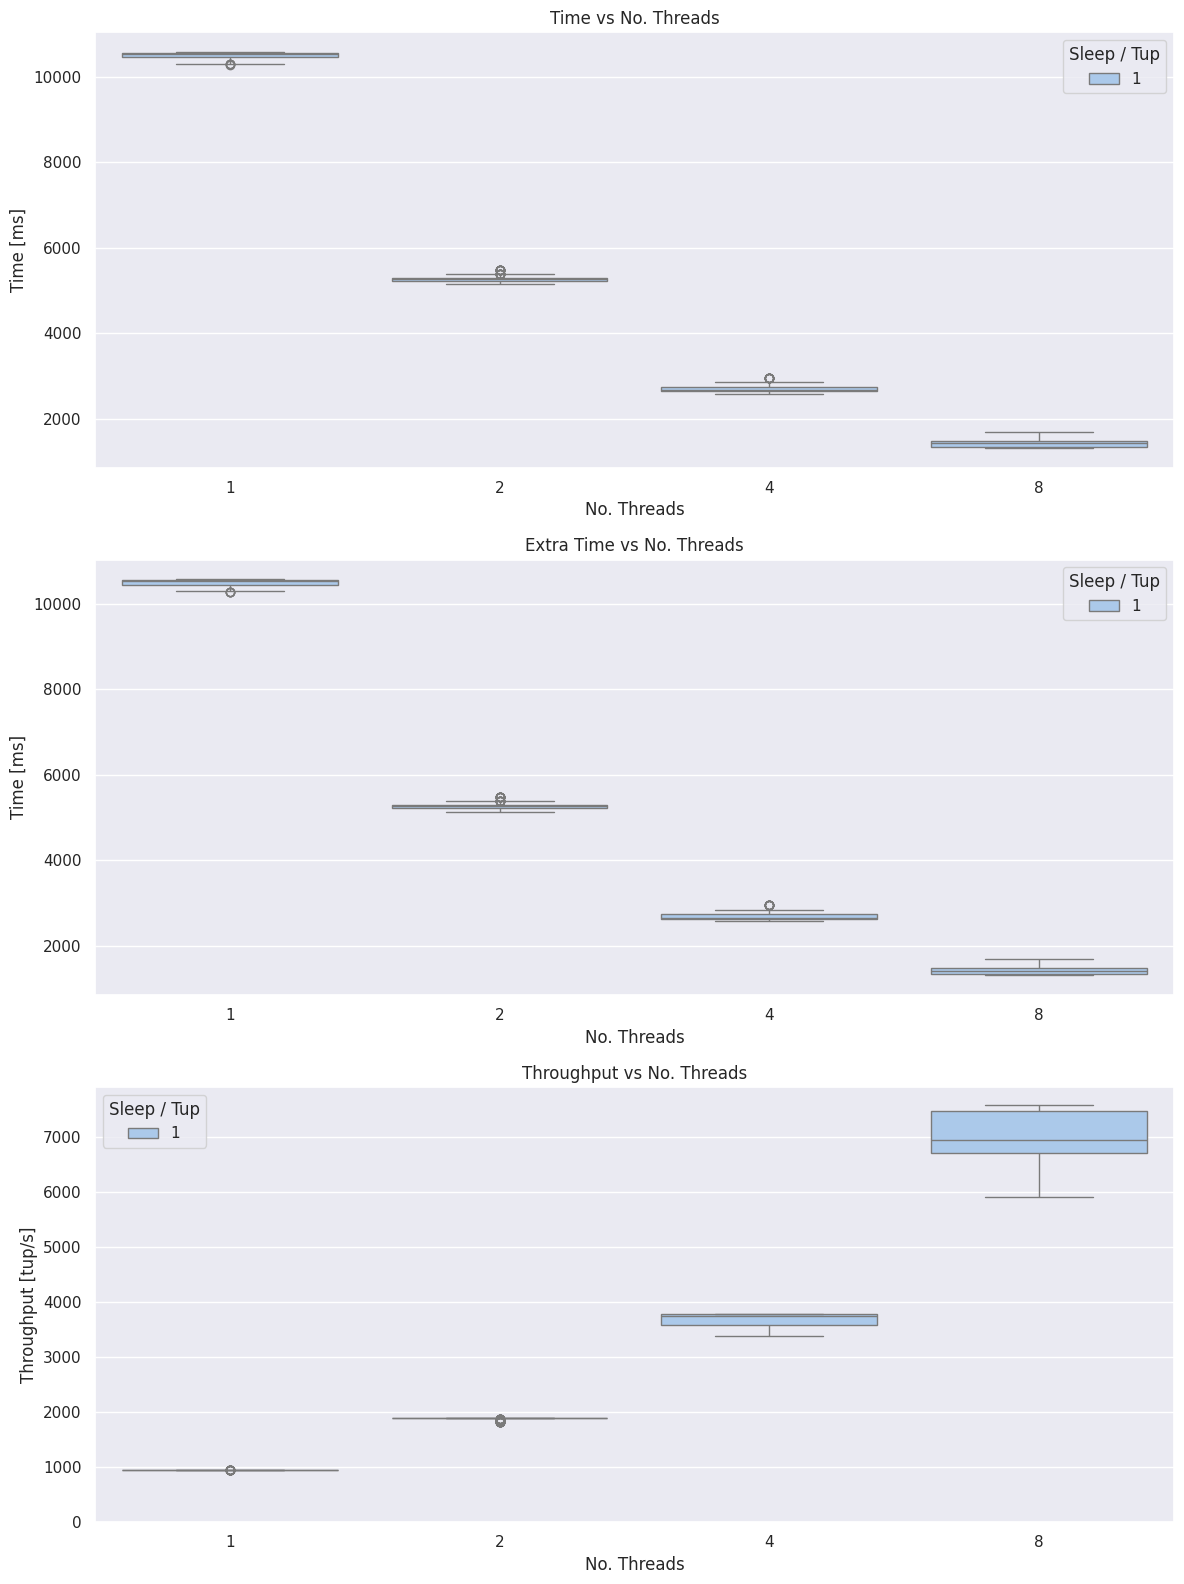

In [5]:
# Load data into dataframe and then plot different boxplots
df = load_data(input_csv_file)
interesting_params = ["No. Threads"]
time_unit = df.iloc[0]['time_unit']
df = df[df['Provider'] == 1]
                                           

# Create a subplot grid.
n_params = len(interesting_params)
fig, axes = plt.subplots(3, n_params, figsize=(12, 16), squeeze=False)

for idx, param in enumerate(interesting_params):
    ax = axes[0][idx]
    sns.boxplot(x=param, y="real_time_ms", hue='Sleep / Tup', data=df, ax=ax, palette="pastel")
    ax.set_title(f"Time vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Time [ms]")
    #ax.set_ylim([0, .04])

    ax = axes[1][idx]
    sns.boxplot(x=param, y="time_extra_ms", hue='Sleep / Tup', data=df, ax=ax, palette="pastel")
    ax.set_title(f"Extra Time vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Time [ms]")
    #ax.set_ylim([0, .04])

    ax = axes[2][idx]
    sns.boxplot(x=param, y="tuples_per_sec", hue='Sleep / Tup', data=df, ax=ax, palette="pastel")
    ax.set_title(f"Throughput vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Throughput [tup/s]")
    ax.set_ylim(bottom=0)

plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()
plt.close()

/tmp/ipykernel_16274/1164804785.py:30: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_new[col] = pd.to_numeric(df_new[col], errors='ignore')


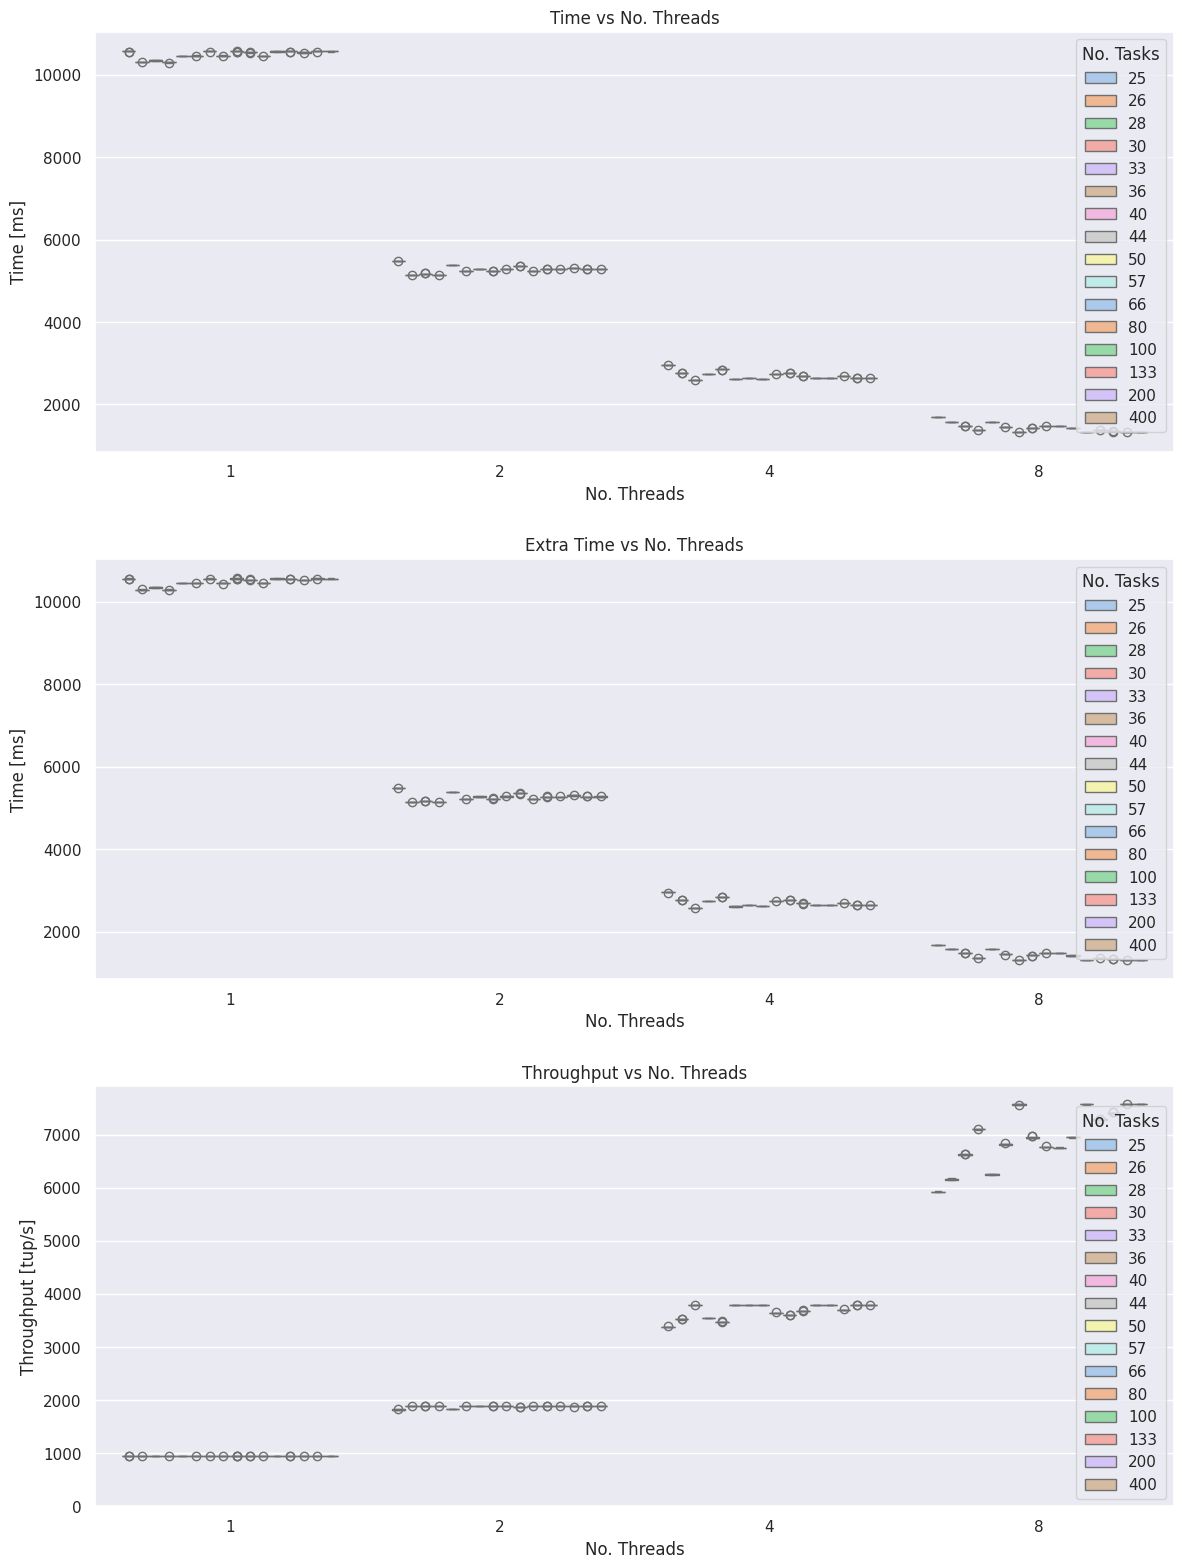

In [6]:
# Load data into dataframe and then plot different boxplots
df = load_data(input_csv_file)
interesting_params = ["No. Threads"]
time_unit = df.iloc[0]['time_unit']
df = df[df['Provider'] == 1]

                                           

# Create a subplot grid.
n_params = len(interesting_params)
fig, axes = plt.subplots(3, n_params, figsize=(12, 16), squeeze=False)

for idx, param in enumerate(interesting_params):
    ax = axes[0][idx]
    sns.boxplot(x=param, y="real_time_ms", hue='No. Tasks', data=df, ax=ax, palette="pastel")
    ax.set_title(f"Time vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Time [ms]")
    #ax.set_ylim([0, .04])

    ax = axes[1][idx]
    sns.boxplot(x=param, y="time_extra_ms", hue='No. Tasks', data=df, ax=ax, palette="pastel")
    ax.set_title(f"Extra Time vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Time [ms]")
    #ax.set_ylim([0, .04])

    ax = axes[2][idx]
    sns.boxplot(x=param, y="tuples_per_sec", hue='No. Tasks', data=df, ax=ax, palette="pastel")
    ax.set_title(f"Throughput vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Throughput [tup/s]")
    ax.set_ylim(bottom=0)

plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()

/tmp/ipykernel_16274/1164804785.py:30: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_new[col] = pd.to_numeric(df_new[col], errors='ignore')


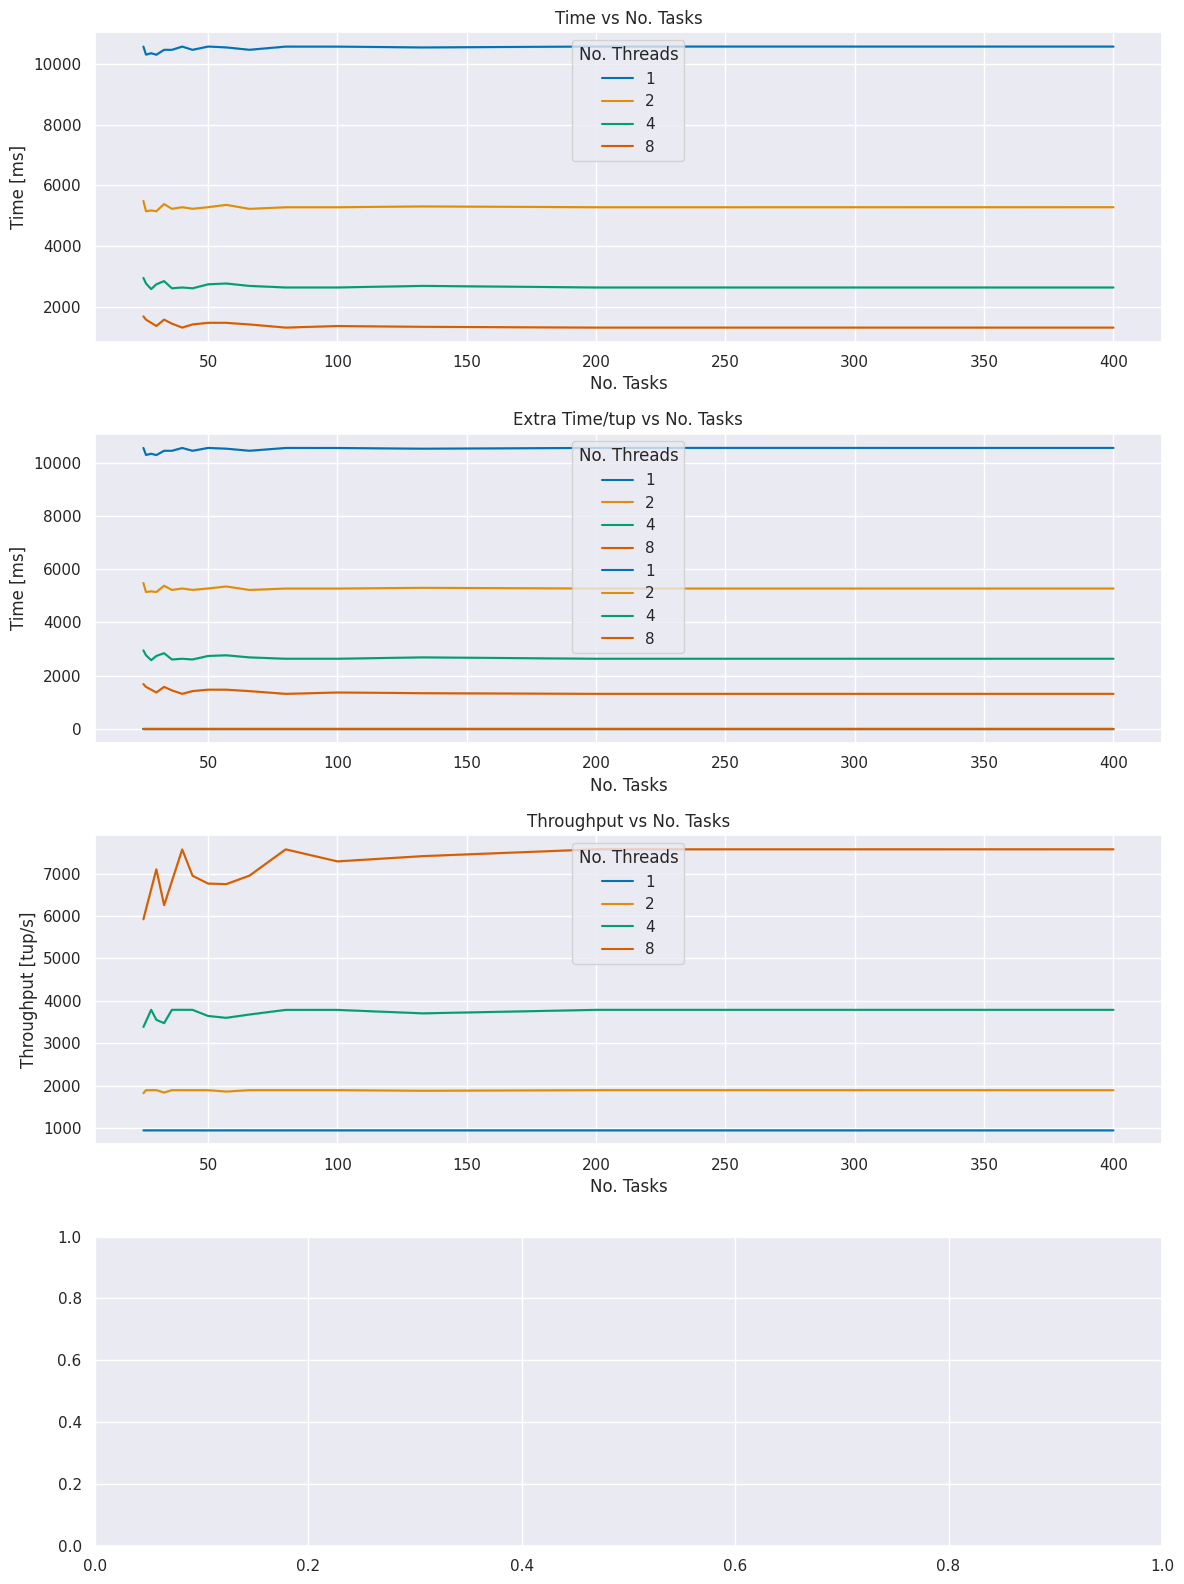

In [7]:
# Load data into dataframe and then plot different boxplots
df = load_data(input_csv_file)
interesting_params = ["No. Tasks"]
time_unit = df.iloc[0]['time_unit']
df = df[df['Provider'] == 1]
                                           

# Create a subplot grid.
n_params = len(interesting_params)
fig, axes = plt.subplots(4, n_params, figsize=(12, 16), squeeze=False)

for idx, param in enumerate(interesting_params):
    ax = axes[0][idx]
    sns.lineplot(x=param, y="real_time_ms", hue='No. Threads', data=df, ax=ax, palette="colorblind")
    ax.set_title(f"Time vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Time [ms]")
    #ax.set_ylim(bottom=0)

    ax = axes[1][idx]
    sns.lineplot(x=param, y="time_extra_ms", hue='No. Threads', data=df, ax=ax, palette="colorblind")
    ax.set_title(f"Extra Time vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Time [ms]")
    #ax.set_ylim(bottom=0)

    ax = axes[1][idx]
    sns.lineplot(x=param, y="time_extra_ms_per_tuple", hue='No. Threads', data=df, ax=ax, palette="colorblind")
    ax.set_title(f"Extra Time/tup vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Time [ms]")
    #ax.set_ylim(bottom=0)

    ax = axes[2][idx]
    sns.lineplot(x=param, y="tuples_per_sec", hue='No. Threads', data=df, ax=ax, palette="colorblind")
    ax.set_title(f"Throughput vs {param}")
    ax.set_xlabel(param)
    ax.set_ylabel(f"Throughput [tup/s]")
    #ax.set_ylim(bottom=0)



plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()

In [8]:
df = load_data(input_csv_file)
df = df[df['Number_Of_Tasks'] > 4]
df

/tmp/ipykernel_16274/1164804785.py:30: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_new[col] = pd.to_numeric(df_new[col], errors='ignore')


,name,iterations,real_time,time_unit,Number_Of_Tasks,Tuples_Processed,No. Tuples / Task,Sleep / Tup,Selectivity,BufferSize,...,real_time_sec,real_time_ms,No. Tasks,No. Tuples,tuples_per_sec,sub_left_side,sub_right_side,time_extra_us,time_extra_ms,time_extra_ms_per_tuple
448,NES::BM_SleepPipeline/10000/25/1/10/16384/1/4/...,1,2640.45,ms,400,10000,25,1,10,16384,...,2.64045,2640.45,400,10000,3787.233237,2640450.0,2500.0,2637950.0,2637.95,0.263795
449,NES::BM_SleepPipeline/10000/25/1/10/16384/1/4/...,1,2640.76,ms,400,10000,25,1,10,16384,...,2.64076,2640.76,400,10000,3786.788652,2640760.0,2500.0,2638260.0,2638.26,0.263826
450,NES::BM_SleepPipeline/10000/25/1/10/16384/1/4/...,1,2640.37,ms,400,10000,25,1,10,16384,...,2.64037,2640.37,400,10000,3787.347985,2640370.0,2500.0,2637870.0,2637.87,0.263787
451,NES::BM_SleepPipeline/10000/25/1/10/16384/1/4/...,1,2640.67,ms,400,10000,25,1,10,16384,...,2.64067,2640.67,400,10000,3786.917714,2640670.0,2500.0,2638170.0,2638.17,0.263817
455,NES::BM_SleepPipeline/10000/25/1/10/16384/1/4/...,1,2640.44,ms,400,10000,25,1,10,16384,...,2.64044,2640.44,400,10000,3787.247580,2640440.0,2500.0,2637940.0,2637.94,0.263794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,NES::BM_SleepPipeline/10000/400/1/10/16384/1/1...,1,10554.60,ms,25,10000,400,1,10,16384,...,10.55460,10554.60,25,10000,947.454191,10554600.0,10000.0,10544600.0,10544.60,1.054460
213,NES::BM_SleepPipeline/10000/400/1/10/16384/1/1...,1,10569.90,ms,25,10000,400,1,10,16384,...,10.56990,10569.90,25,10000,946.082744,10569900.0,10000.0,10559900.0,10559.90,1.055990
212,NES::BM_SleepPipeline/10000/400/1/10/16384/1/1...,1,10564.30,ms,25,10000,400,1,10,16384,...,10.56430,10564.30,25,10000,946.584251,10564300.0,10000.0,10554300.0,10554.30,1.055430
211,NES::BM_SleepPipeline/10000/400/1/10/16384/1/1...,1,10565.20,ms,25,10000,400,1,10,16384,...,10.56520,10565.20,25,10000,946.503616,10565200.0,10000.0,10555200.0,10555.20,1.055520
